# Flatiron Phase 1 Project
## Project Goal
The goal of this project is to analyze data providing information about movies to generate insights for Microsoft as to what types of films they should produce for their new film studio.  
## Data Source and Data Exploration
The datasets provided for research are from IMDB, Box Office Mojo, Rotten Tomatoes, The Movie DB, and The Numbers.
For this project, I examined the The Movie DB dataset to extract financial information for films and examined the IMDB dataset to extract general information for films such as genre, directors, and cast members.  

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scipy
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing Budget Dataset and Cleaning Data
To clean the data, I standardized strings containing dollar signs and commas to float values.  
I also created a column named gross_per_dollar to measure the ratio between money spent and money earned on a film.  
I created a separate column for release year and added this value to the end of the movie name to avoid confusion between identically named films.  
Finally, I removed all films with a production budget less than $100,000 or a worldwide gross of exactly zero.

In [2]:
#Importing The Movie DB, budgets dataset
tm_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')
#Cleaning $-value strings to convert to plain numbers
tm_budgets_df['production_budget'] = tm_budgets_df['production_budget'].str.replace(',','').str.replace('$','')
tm_budgets_df['domestic_gross'] = tm_budgets_df['domestic_gross'].str.replace(',','').str.replace('$','')
tm_budgets_df['worldwide_gross'] = tm_budgets_df['worldwide_gross'].str.replace(',','').str.replace('$','')
#Converting $-values to float
tm_budgets_df = tm_budgets_df.astype({'worldwide_gross':'float','domestic_gross':'float','production_budget':'float'})
#Creating a column for "gross_per_$", ratio of money spent to money earned
tm_budgets_df['gross_per_$']=tm_budgets_df['worldwide_gross']/tm_budgets_df['production_budget']
#Creating release date year and month columns
tm_budgets_df['release_year']=tm_budgets_df['release_date'].str[-4:]
tm_budgets_df['release_month']=tm_budgets_df['release_date'].str[:3]
tm_budgets_df["release_year"] = pd.to_numeric(tm_budgets_df["release_year"])
#Removing whitespace
tm_budgets_df.movie = [c.strip() for c in tm_budgets_df.movie]
#Deleting unnecessary 'id' column
del tm_budgets_df['id']
#Copying dataframe and adding year to end of movie name to eliminate confusion with identical names
budgets_df=tm_budgets_df.copy()
budgets_df["movie"] = budgets_df['movie'].astype(str) +"-"+ budgets_df["release_year"].astype(str)
#Creating list of movie titles in budgets_df
movieList=budgets_df['movie'].tolist()
#Filtering out "worldwide_gross" of zero and movies with "production_budget" under $100,000
budgets_df=budgets_df.loc[budgets_df['worldwide_gross']>0]
budgets_df=budgets_df.loc[budgets_df['production_budget']>100000]
budgets_df

C:\Users\hyper\AppData\Local\Temp\ipykernel_9892\2524352737.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tm_budgets_df['production_budget'] = tm_budgets_df['production_budget'].str.replace(',','').str.replace('$','')
C:\Users\hyper\AppData\Local\Temp\ipykernel_9892\2524352737.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tm_budgets_df['domestic_gross'] = tm_budgets_df['domestic_gross'].str.replace(',','').str.replace('$','')
C:\Users\hyper\AppData\Local\Temp\ipykernel_9892\2524352737.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal

,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_per_$,release_year,release_month
0,"Dec 18, 2009",Avatar-2009,425000000.0,760507625.0,2.776345e+09,6.532577,2009,Dec
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides-2011,410600000.0,241063875.0,1.045664e+09,2.546673,2011,May
2,"Jun 7, 2019",Dark Phoenix-2019,350000000.0,42762350.0,1.497624e+08,0.427892,2019,Jun
3,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi-2017,317000000.0,620181382.0,1.316722e+09,4.153696,2017,Dec
...,...,...,...,...,...,...,...,...
5668,"Nov 16, 1942",Cat People-1942,134000.0,4000000.0,8.000000e+06,59.701493,1942,Nov
5672,"Jun 15, 2012",Your Sister's Sister-2012,120000.0,1597486.0,3.090593e+06,25.754942,2012,Jun
5676,"Oct 1, 1968",Night of the Living Dead-1968,114000.0,12087064.0,3.008706e+07,263.921614,1968,Oct
5677,"Feb 8, 1915",The Birth of a Nation-1915,110000.0,10000000.0,1.100000e+07,100.000000,1915,Feb


# Importing IMDB Database

In [3]:
#Importing IMDB sql database
def read_sqlite(dbfile):
    import sqlite3
    from pandas import read_sql_query, read_sql_table
    with sqlite3.connect(dbfile) as dbcon:
        tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
        out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}
    return out
im_db=read_sqlite('zippedData/im.db')
#Printing datasets included in IMDB database
print(im_db.keys())

dict_keys(['movie_basics', 'directors', 'known_for', 'movie_akas', 'movie_ratings', 'persons', 'principals', 'writers'])


# Extracting IMDB Basic Information from imdb_basics and Merging with Budgets
The "imdb_basics" dataset contains the "movie_id" code used to identify films within the IMDB database, primary and original titles, year of release, runtime, and genres of the film.

In [4]:
#Extracting the "movie_basics" dataset from IMDB
imdb_basics=im_db['movie_basics']
#Adding year to end of movie name to eliminate confusion with identical names
imdb_basics["primary_title"] = imdb_basics['primary_title'].astype(str) +"-"+ imdb_basics["start_year"].astype(str)
#Renaming "primary_title" to enable merging with "budgets_df"
imdb_basics=imdb_basics.rename(columns={'primary_title':'movie'})
#Merging "imdb_basics" and "budgets_df" on "movie"
budgets_df_merged=budgets_df.merge(imdb_basics, on='movie')
#Displaying dataframe
budgets_df_merged

,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_per_$,release_year,release_month,movie_id,original_title,start_year,runtime_minutes,genres
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides-2011,410600000.0,241063875.0,1.045664e+09,2.546673,2011,May,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy"
1,"Jun 7, 2019",Dark Phoenix-2019,350000000.0,42762350.0,1.497624e+08,0.427892,2019,Jun,tt6565702,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi"
2,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi"
3,"Apr 27, 2018",Avengers: Infinity War-2018,300000000.0,678815482.0,2.048134e+09,6.827114,2018,Apr,tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"
4,"Nov 17, 2017",Justice League-2017,300000000.0,229024295.0,6.559452e+08,2.186484,2017,Nov,tt0974015,Justice League,2017,120.0,"Action,Adventure,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,"Sep 23, 2011",Weekend-2011,190000.0,484592.0,1.577585e+06,8.303079,2011,Sep,tt1714210,Weekend,2011,97.0,"Drama,Romance"
1406,"Sep 23, 2011",Weekend-2011,190000.0,484592.0,1.577585e+06,8.303079,2011,Sep,tt1791679,Weekend,2011,121.0,"Action,Comedy,Crime"
1407,"Sep 23, 2011",Weekend-2011,190000.0,484592.0,1.577585e+06,8.303079,2011,Sep,tt1910670,Weekend,2011,80.0,"Comedy,Drama"
1408,"Jul 22, 2011",Another Earth-2011,175000.0,1321194.0,2.102779e+06,12.015880,2011,Jul,tt1549572,Another Earth,2011,92.0,"Drama,Romance,Sci-Fi"


# Extracting IMDB Actor and Producer Information from imdb_principals
The "imdb_principals" database contains movie_id, the ordering of the person in the credit, the "person_id" used to identify the individual within the IMDB dataset, their category, job, and the name of any characters they may play.  

First I extract all rows where the person's category is "actor" and then extract all rows for which the person's category is "producer".  I drop all columns other than movie_id and person_id, which I rename to actor_id and producer_id respectfully.  

In [5]:
#Importing dataset
imdb_principals=im_db['principals']
#Selecting rows with actors
principals_actors=imdb_principals.loc[imdb_principals['category']=='actor']
#Renaming person_id to actor_id
principals_actors=principals_actors.rename(columns={'person_id':'actor_id'})
#Deleting unneeded columns
del principals_actors['category']
del principals_actors['ordering']
del principals_actors['job']
del principals_actors['characters']
principals_actors

,movie_id,actor_id
0,tt0111414,nm0246005
5,tt0323808,nm2694680
6,tt0323808,nm0574615
14,tt0417610,nm0532721
16,tt0417610,nm0069209
...,...,...
1028175,tt9681728,nm10397910
1028176,tt9689618,nm10439726
1028177,tt9689618,nm10439727
1028178,tt9689618,nm10439724


In [6]:
#Selecting rows with producers
principals_producers=imdb_principals.loc[imdb_principals['category']=='producer']
#Renaming person_id to producer_id
principals_producers=principals_producers.rename(columns={'person_id':'producer_id'})
#Dropping unneeded columns
del principals_producers['category']
del principals_producers['ordering']
del principals_producers['job']
del principals_producers['characters']
principals_producers

,movie_id,producer_id
2,tt0111414,nm3739909
9,tt0323808,nm0811056
10,tt0323808,nm0914939
20,tt0417610,nm0147416
21,tt0417610,nm0215732
...,...,...
1028120,tt9662266,nm10427476
1028128,tt9670776,nm2950772
1028131,tt9670894,nm10435886
1028172,tt9681728,nm7442758


# Extracting IMDB Director and Writer Information from imdb_directors and imdb_writers
The "imdb_directors" and "imdb_writers" datasets each only include columns for movie_id and person_id.

I rename person_id to director_id and actor_id respectfully and leave the datasets otherwise unmodified.

In [7]:
#Importing dataset
imdb_directors=im_db['directors']
#Renaming person_id to director_id
imdb_directors=imdb_directors.rename(columns={'person_id':'director_id'})
imdb_directors

,movie_id,director_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [8]:
#Importing dataset
imdb_writers=im_db['writers']
#Renaming person_id to writer_id
imdb_writers=imdb_writers.rename(columns={'person_id':'writer_id'})
imdb_writers

,movie_id,writer_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


# Merging Budgets with the above Producer, Writer, Actor, and Director Datasets
Since all datasets share the movie_id column, they can be merged using this as a key.  This returns a dataset with multiple rows per film in cases where the film has more than one producer, writer, actor, or director. 

In [9]:
budgets_df_merged=budgets_df_merged.merge(principals_producers,on='movie_id')
budgets_df_merged=budgets_df_merged.merge(imdb_writers,on='movie_id')
budgets_df_merged=budgets_df_merged.merge(principals_actors,on='movie_id')
budgets_df_merged=budgets_df_merged.merge(imdb_directors,on='movie_id')
budgets_df_merged

,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_per_$,release_year,release_month,movie_id,original_title,start_year,runtime_minutes,genres,producer_id,writer_id,actor_id,director_id
0,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",nm0270559,nm0923736,nm0000375,nm0923736
1,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",nm0270559,nm0923736,nm0000375,nm0923736
2,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",nm0270559,nm0923736,nm0000375,nm0923736
3,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",nm0270559,nm0923736,nm0000375,nm0923736
4,"May 1, 2015",Avengers: Age of Ultron-2015,330600000.0,459005868.0,1.403014e+09,4.243841,2015,May,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",nm0270559,nm0923736,nm0000375,nm0923736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42449,"Dec 31, 2013",Speak No Evil-2013,150000.0,0.0,3.292700e+04,0.219513,2013,Dec,tt2503358,Speak No Evil,2013,74.0,Horror,nm2626870,nm1853643,nm5425843,nm1853643
42450,"Dec 31, 2013",Speak No Evil-2013,150000.0,0.0,3.292700e+04,0.219513,2013,Dec,tt2503358,Speak No Evil,2013,74.0,Horror,nm3229521,nm1853643,nm2584043,nm1853643
42451,"Dec 31, 2013",Speak No Evil-2013,150000.0,0.0,3.292700e+04,0.219513,2013,Dec,tt2503358,Speak No Evil,2013,74.0,Horror,nm3229521,nm1853643,nm5425843,nm1853643
42452,"Dec 31, 2013",Speak No Evil-2013,150000.0,0.0,3.292700e+04,0.219513,2013,Dec,tt2503358,Speak No Evil,2013,74.0,Horror,nm5409249,nm1853643,nm2584043,nm1853643


# Cleaning merged dataset
First I grouped the dataset such that each movie only has one row.  This returns columns of lists, containing repeated values.  Next I removed these repeated values and extracted column values from lists for instances where the list only had one value.

In [10]:
#Grouping dataset so that each film only has one row
woMDdf=budgets_df_merged.drop_duplicates(['movie', 'release_year', 'producer_id', 'director_id', 'actor_id', 'writer_id']).groupby('movie_id').agg(list)
#Removing repeated values
for column in woMDdf.columns:
    woMDdf[column]=woMDdf[column].apply(lambda x: list(set(x)))
#Removing list where list only has one value
for column in ['release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'gross_per_$', 'release_year', 'release_month',
       'original_title', 'start_year', 'runtime_minutes', 'genres']:
    woMDdf[column]=woMDdf[column].apply(lambda x: x[0] if len(x)==1 else x)
#Renaming 'Music' column to 'Musical'
woMDdf['genres']=woMDdf['genres'].str.replace('Music','Musical')
#Resetting index
woMDdf=woMDdf.reset_index()
woMDdf

,movie_id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_per_$,release_year,release_month,original_title,start_year,runtime_minutes,genres,producer_id,writer_id,actor_id,director_id
0,tt0249516,"Dec 31, 2012",Foodfight!-2012,45000000.0,0.0,7.370600e+04,0.001638,2012,Dec,Foodfight!,2012,91.0,"Action,Animation,Comedy",[nm0257258],"[nm0923312, nm0440415, nm0220297, nm0295165, n...",[nm0000221],[nm0440415]
1,tt0359950,"Dec 25, 2013",The Secret Life of Walter Mitty-2013,91000000.0,58236838.0,1.878612e+08,2.064409,2013,Dec,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama","[nm0326412, nm0180366, nm0326415]","[nm0175726, nm0862122]","[nm1789985, nm0001774]",[nm0001774]
2,tt0365907,"Sep 19, 2014",A Walk Among the Tombstones-2014,28000000.0,26017685.0,6.210859e+07,2.218164,2014,Sep,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama","[nm0787834, nm0000362, nm1180690, nm1003922]","[nm0088747, nm0291082]","[nm2933542, nm1405398, nm0000553, nm1092086]",[nm0291082]
3,tt0369610,"Jun 12, 2015",Jurassic World-2015,215000000.0,652270625.0,1.648855e+09,7.669092,2015,Jun,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",[nm0189777],"[nm1119880, nm0798646, nm0000341, nm2081046, n...","[nm1339223, nm0695435]",[nm1119880]
4,tt0376136,"Oct 28, 2011",The Rum Diary-2011,45000000.0,13109815.0,2.154473e+07,0.478772,2011,Oct,The Rum Diary,2011,119.0,"Comedy,Drama","[nm0470420, nm0218259, nm0454752, nm2593874]","[nm0860219, nm0732430]","[nm0000610, nm0001173, nm0000136, nm0728346]",[nm0732430]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,tt7959026,"Dec 14, 2018",The Mule-2018,50000000.0,103804407.0,1.708577e+08,3.417154,2018,Dec,The Mule,2018,116.0,"Crime,Drama,Thriller","[nm1664289, nm6679051, nm0601954, nm3709982]","[nm10095627, nm1010405]","[nm1478076, nm3169819, nm0000142, nm8423767]",[nm0000142]
1173,tt8043306,"Jul 20, 2018",Teefa in Trouble-2018,1500000.0,0.0,9.880600e+04,0.065871,2018,Jul,Teefa in Trouble,2018,155.0,"Action,Comedy,Crime","[nm1924360, nm10086660, nm10086659]","[nm6773153, nm3773554, nm6511211]","[nm3773554, nm3809372, nm2588481]",[nm6773153]
1174,tt8155288,"Feb 13, 2019",Happy Death Day 2U-2019,9000000.0,28051045.0,6.417950e+07,7.131055,2019,Feb,Happy Death Day 2U,2019,100.0,"Drama,Horror,Mystery",[nm0089658],"[nm0484907, nm1245146]","[nm7059572, nm3441152, nm4139037]",[nm0484907]
1175,tt9024106,"Mar 29, 2019",Unplanned-2019,6000000.0,18107621.0,1.810762e+07,3.017937,2019,Mar,Unplanned,2019,106.0,"Biography,Drama","[nm7839151, nm2445956, nm0498920]","[nm0813301, nm0465484]","[nm5237225, nm5618577]","[nm0813301, nm0465484]"


# Iterating over producers, directors, actors, and writers to create "success scores" represeting how many successful films that person has made
"Successful" defined here as being one of the top-250 grossing movies since 2000.  
The code below returns a dictionary for each job category containing successful person_ids and the count of successful films each has worked on.

In [11]:
#Sorting the merged dataframe by worldwide_gross, descending, and selecting top 250
woMDdf250=woMDdf.sort_values(by='worldwide_gross', ascending=False).head(250)
#Creating a list of producer_ids and flattening, since this returns a list of list
flatList=[]
producer= woMDdf250['producer_id'].tolist()
for subset in producer:
    for item in subset:
        flatList.append(item)
#Creating a dictionary with each id and the count of their successful films
prodDict={}
for producer in flatList:
    prodDict[producer]=flatList.count(producer)
#Creating a list of actor_ids and flattening, since this returns a list of list
flatList=[]
actor= woMDdf250['actor_id'].tolist()
for subset in actor:
    for item in subset:
        flatList.append(item)
#Creating a dictionary with each id and the count of their successful films      
actDict={}
for actor in flatList:
    actDict[actor]=flatList.count(actor)
#Creating a list of director_ids and flattening, since this returns a list of list
flatList=[]
director= woMDdf250['director_id'].tolist()
for subset in director:
    for item in subset:
        flatList.append(item)
#Creating a dictionary with each id and the count of their successful films
dirDict={}
for director in flatList:
    dirDict[director]=flatList.count(director)
#Creating a list of actor_ids and flattening, since this returns a list of list
flatList=[]
writer= woMDdf250['writer_id'].tolist()
for subset in writer:
    for item in subset:
        flatList.append(item)
#Creating a dictionary with each id and the count of their successful films
wriDict={}
for writer in flatList:
    wriDict[writer]=flatList.count(writer)

# Mapping the above "success score" for each individual to their person_ids in dataframe
I created columns summing the success scores by job category and created a final "success_score" column measuring the total number of successful people for each film.  

In [12]:
#Creating new DF
woMDdf250count=woMDdf.copy()
#Creating new columns where person_ids are replaced with their success score
woMDdf250count['producer_count']=woMDdf250count['producer_id'].apply(lambda x:list(filter(None,map(prodDict.get,x))))
woMDdf250count['writer_count']=woMDdf250count['writer_id'].apply(lambda x:list(filter(None,map(wriDict.get,x))))
woMDdf250count['director_count']=woMDdf250count['director_id'].apply(lambda x:list(filter(None,map(dirDict.get,x))))
woMDdf250count['actor_count']=woMDdf250count['actor_id'].apply(lambda x:list(filter(None,map(actDict.get,x))))
#Creating new columns showing the sum of person scores for each job category
woMDdf250count['prod_total']=woMDdf250count['producer_count'].apply(lambda x: sum(x))
woMDdf250count['wri_total']=woMDdf250count['writer_count'].apply(lambda x: sum(x))
woMDdf250count['act_total']=woMDdf250count['actor_count'].apply(lambda x: sum(x))
woMDdf250count['dir_total']=woMDdf250count['director_count'].apply(lambda x: sum(x))
#Creating a column for total success score
woMDdf250count['success_score']=woMDdf250count['prod_total']+woMDdf250count['wri_total']+woMDdf250count['act_total']+woMDdf250count['wri_total']
woMDdf250count

,movie_id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_per_$,release_year,release_month,original_title,...,director_id,producer_count,writer_count,director_count,actor_count,prod_total,wri_total,act_total,dir_total,success_score
0,tt0249516,"Dec 31, 2012",Foodfight!-2012,45000000.0,0.0,7.370600e+04,0.001638,2012,Dec,Foodfight!,...,[nm0440415],[],[],[],[],0,0,0,0,0
1,tt0359950,"Dec 25, 2013",The Secret Life of Walter Mitty-2013,91000000.0,58236838.0,1.878612e+08,2.064409,2013,Dec,The Secret Life of Walter Mitty,...,[nm0001774],"[1, 1, 1]","[2, 1]",[1],"[1, 2]",3,3,3,1,12
2,tt0365907,"Sep 19, 2014",A Walk Among the Tombstones-2014,28000000.0,26017685.0,6.210859e+07,2.218164,2014,Sep,A Walk Among the Tombstones,...,[nm0291082],[],[1],[],"[4, 1]",0,1,5,0,7
3,tt0369610,"Jun 12, 2015",Jurassic World-2015,215000000.0,652270625.0,1.648855e+09,7.669092,2015,Jun,Jurassic World,...,[nm1119880],[3],"[2, 4, 2, 2, 4]",[1],"[1, 3]",3,14,4,1,35
4,tt0376136,"Oct 28, 2011",The Rum Diary-2011,45000000.0,13109815.0,2.154473e+07,0.478772,2011,Oct,The Rum Diary,...,[nm0732430],"[1, 3, 1]",[],[],"[1, 7]",5,0,8,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,tt7959026,"Dec 14, 2018",The Mule-2018,50000000.0,103804407.0,1.708577e+08,3.417154,2018,Dec,The Mule,...,[nm0000142],[1],[],[2],[],1,0,0,2,1
1173,tt8043306,"Jul 20, 2018",Teefa in Trouble-2018,1500000.0,0.0,9.880600e+04,0.065871,2018,Jul,Teefa in Trouble,...,[nm6773153],[],[],[],[],0,0,0,0,0
1174,tt8155288,"Feb 13, 2019",Happy Death Day 2U-2019,9000000.0,28051045.0,6.417950e+07,7.131055,2019,Feb,Happy Death Day 2U,...,[nm0484907],[5],[2],[],[1],5,2,1,0,10
1175,tt9024106,"Mar 29, 2019",Unplanned-2019,6000000.0,18107621.0,1.810762e+07,3.017937,2019,Mar,Unplanned,...,"[nm0813301, nm0465484]",[],[],[],[],0,0,0,0,0


# Plotting Relationships Between Success Score and ROI
The below graphs indicate that moderately successful producers and writers perform best.  Very successful directors perform much better than their moderately successful counterparts.  Successful actors do not necessarily perform better than their moderately successful counterparts, except for a bump in performance for the most successful actors.  There is an overall positive relationship between net success score and ROI.  

Text(0.5, 1.0, 'Actor Success Score vs. ROI')

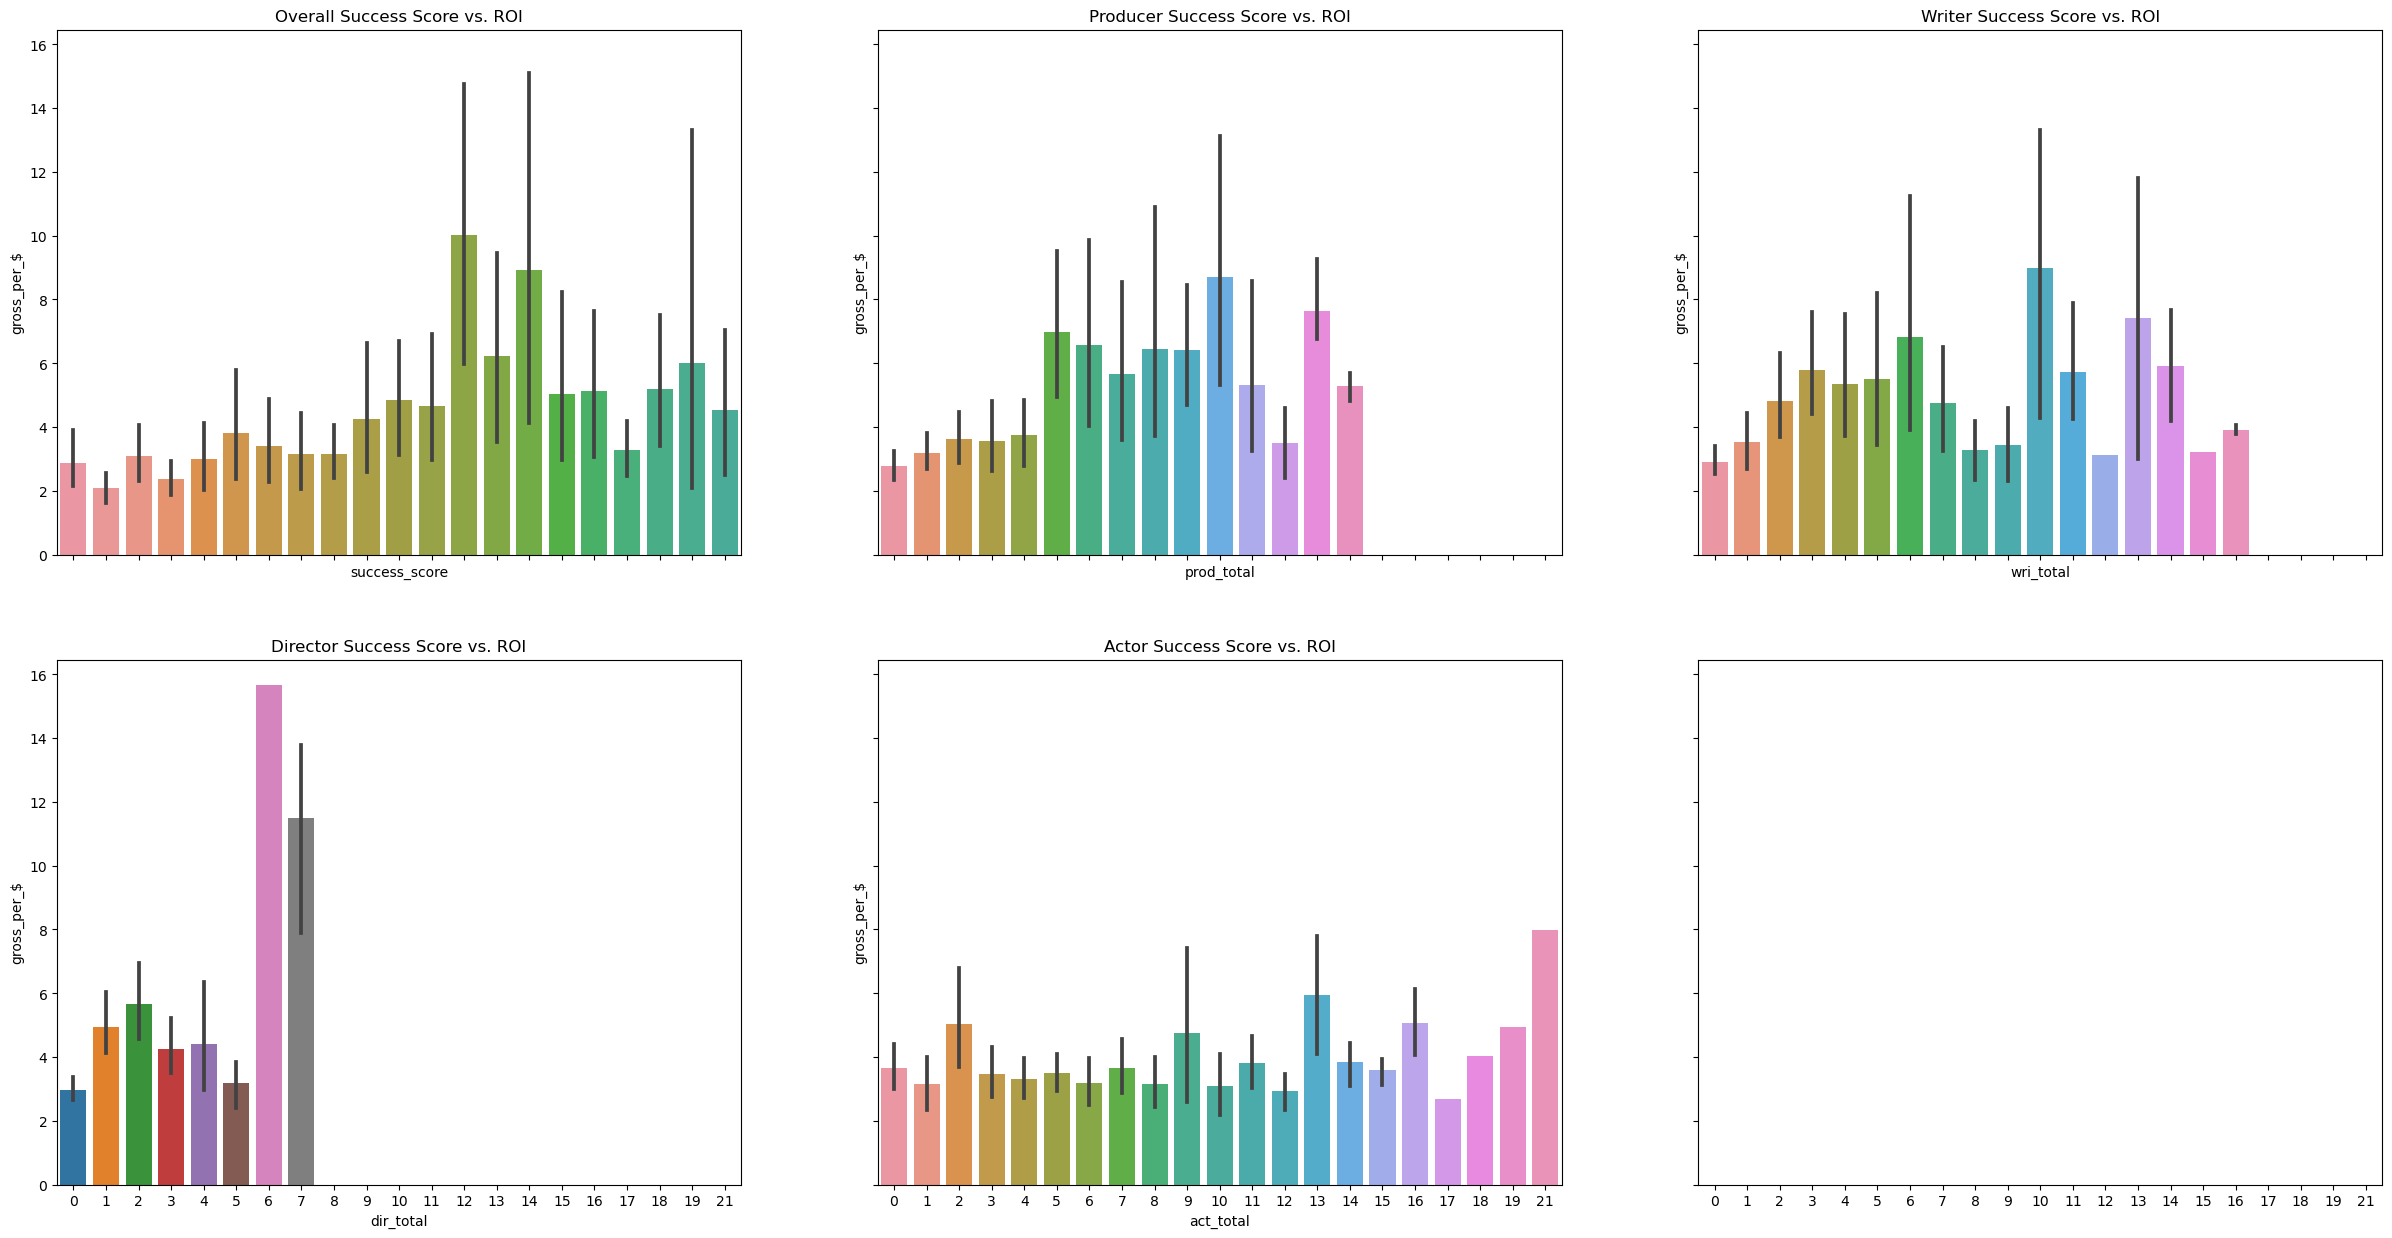

In [13]:
df=woMDdf250count.copy()
fig, axes = plt.subplots(2,3, figsize=(30, 15), sharey=True,sharex=True)
sns.barplot(ax=axes[0,0], data=df, x='success_score', y='gross_per_$').set_title('Overall Success Score vs. ROI')
sns.barplot(ax=axes[0,1], data=df, x='prod_total', y='gross_per_$').set_title('Producer Success Score vs. ROI')
sns.barplot(ax=axes[0,2], data=df, x='wri_total', y='gross_per_$').set_title('Writer Success Score vs. ROI')
sns.barplot(ax=axes[1,0], data=df, x='dir_total', y='gross_per_$').set_title('Director Success Score vs. ROI')
sns.barplot(ax=axes[1,1], data=df, x='act_total', y='gross_per_$').set_title('Actor Success Score vs. ROI')

# Extracting Statistical Information By Genre
Here, I am extracting: correlation between production budget and worldwide gross, mean production budget, mean worldwide gross, worldwide gross standard deviation, mean success score for that genre, correlation between success score and worldwide gross, mean ROI, or "gross_per_dollar", and ROI standard deviation

I will be using these statistics to determine what genres to examine visually.

In [14]:
#Creating a function that returns dataframe rows where the genre is contained in list of genres
def returnGenreFrames(df,genre):
    byGenre=df[df['genres'].str.contains(genre)==True]
    return byGenre
#List of genres
squishedGenres=['Action','Sport','Comedy','Crime','Drama','Romance','Adventure','Biography','History','War','Fantasy',
 'Family','Horror','Sci-Fi','Thriller','Mystery','Animation','Musical','Documentary','Western','Music']
#Creating a dictionary to hold statistical information
corrDict={}
#Iterating through each genre and collecting statistical information for that genre
for item in squishedGenres:
    df=returnGenreFrames(woMDdf250count,item)
    totalNumberMovies=len(df)
    corrBudGross=df['production_budget'].corr(df['worldwide_gross'])
    prodBudMean=df['production_budget'].mean()
    meanGross=df['worldwide_gross'].mean()
    stdGross=df['worldwide_gross'].std()
    avgNotable=df['success_score'].mean()
    corrScoreGross=df['success_score'].corr(df['worldwide_gross'])
    grossDollarMean=df['gross_per_$'].mean()
    grossDollarStd=df['gross_per_$'].std()
    corrDict[item]=[corrBudGross,prodBudMean,meanGross,stdGross,avgNotable,corrScoreGross,grossDollarMean, grossDollarStd]
#Creating a statistics dataframe from statistics dictionary and naming columns
statsDF=pd.DataFrame.from_dict(corrDict,orient='index')
statsDF=statsDF.rename(columns={0:'corrBudgetGross',1:'prodBudMean',2:'WWgrossMmean',3:'WWgrossStd',4:'SuccessScoreMean',5:'corrScoreGross',6:'ROIMean',7:'ROIStd'})
#Rounding values and sorting by ROIMean
statsDF=statsDF.round(2)
statsDF.sort_values(by='ROIMean', ascending=False)

,corrBudgetGross,prodBudMean,WWgrossMmean,WWgrossStd,SuccessScoreMean,corrScoreGross,ROIMean,ROIStd
Horror,0.44,1.837376e+07,7.617040e+07,9.864449e+07,4.68,0.68,8.16,13.46
Mystery,0.59,2.660405e+07,1.010112e+08,1.111479e+08,6.84,0.81,7.10,9.81
Thriller,0.77,3.405154e+07,1.216493e+08,1.972545e+08,8.05,0.74,5.20,8.19
Documentary,0.49,4.380429e+06,1.395840e+07,1.207552e+07,0.57,0.37,4.41,5.12
Animation,0.58,9.684483e+07,4.038599e+08,3.549732e+08,13.55,0.56,4.13,3.43
Sci-Fi,0.76,8.396707e+07,3.046354e+08,3.708928e+08,13.72,0.73,3.89,3.54
Romance,0.61,2.352218e+07,7.234844e+07,8.924930e+07,4.59,0.76,3.72,4.28
Biography,0.58,2.689238e+07,8.581169e+07,1.263444e+08,6.21,0.62,3.62,4.58
Music,0.53,2.092045e+07,7.831267e+07,1.534616e+08,3.95,0.51,3.42,4.23
Musical,0.53,2.092045e+07,7.831267e+07,1.534616e+08,3.95,0.51,3.42,4.23


# Examining Genres Visually
From the above, I specifically want to examine Horror, Documentary, and Animation.  I am also examining some other genres from mostly the upper median range, based on the correlation between budget and gross income, success scores, and ROI.

[Text(0.5, 1.0, 'Action')]

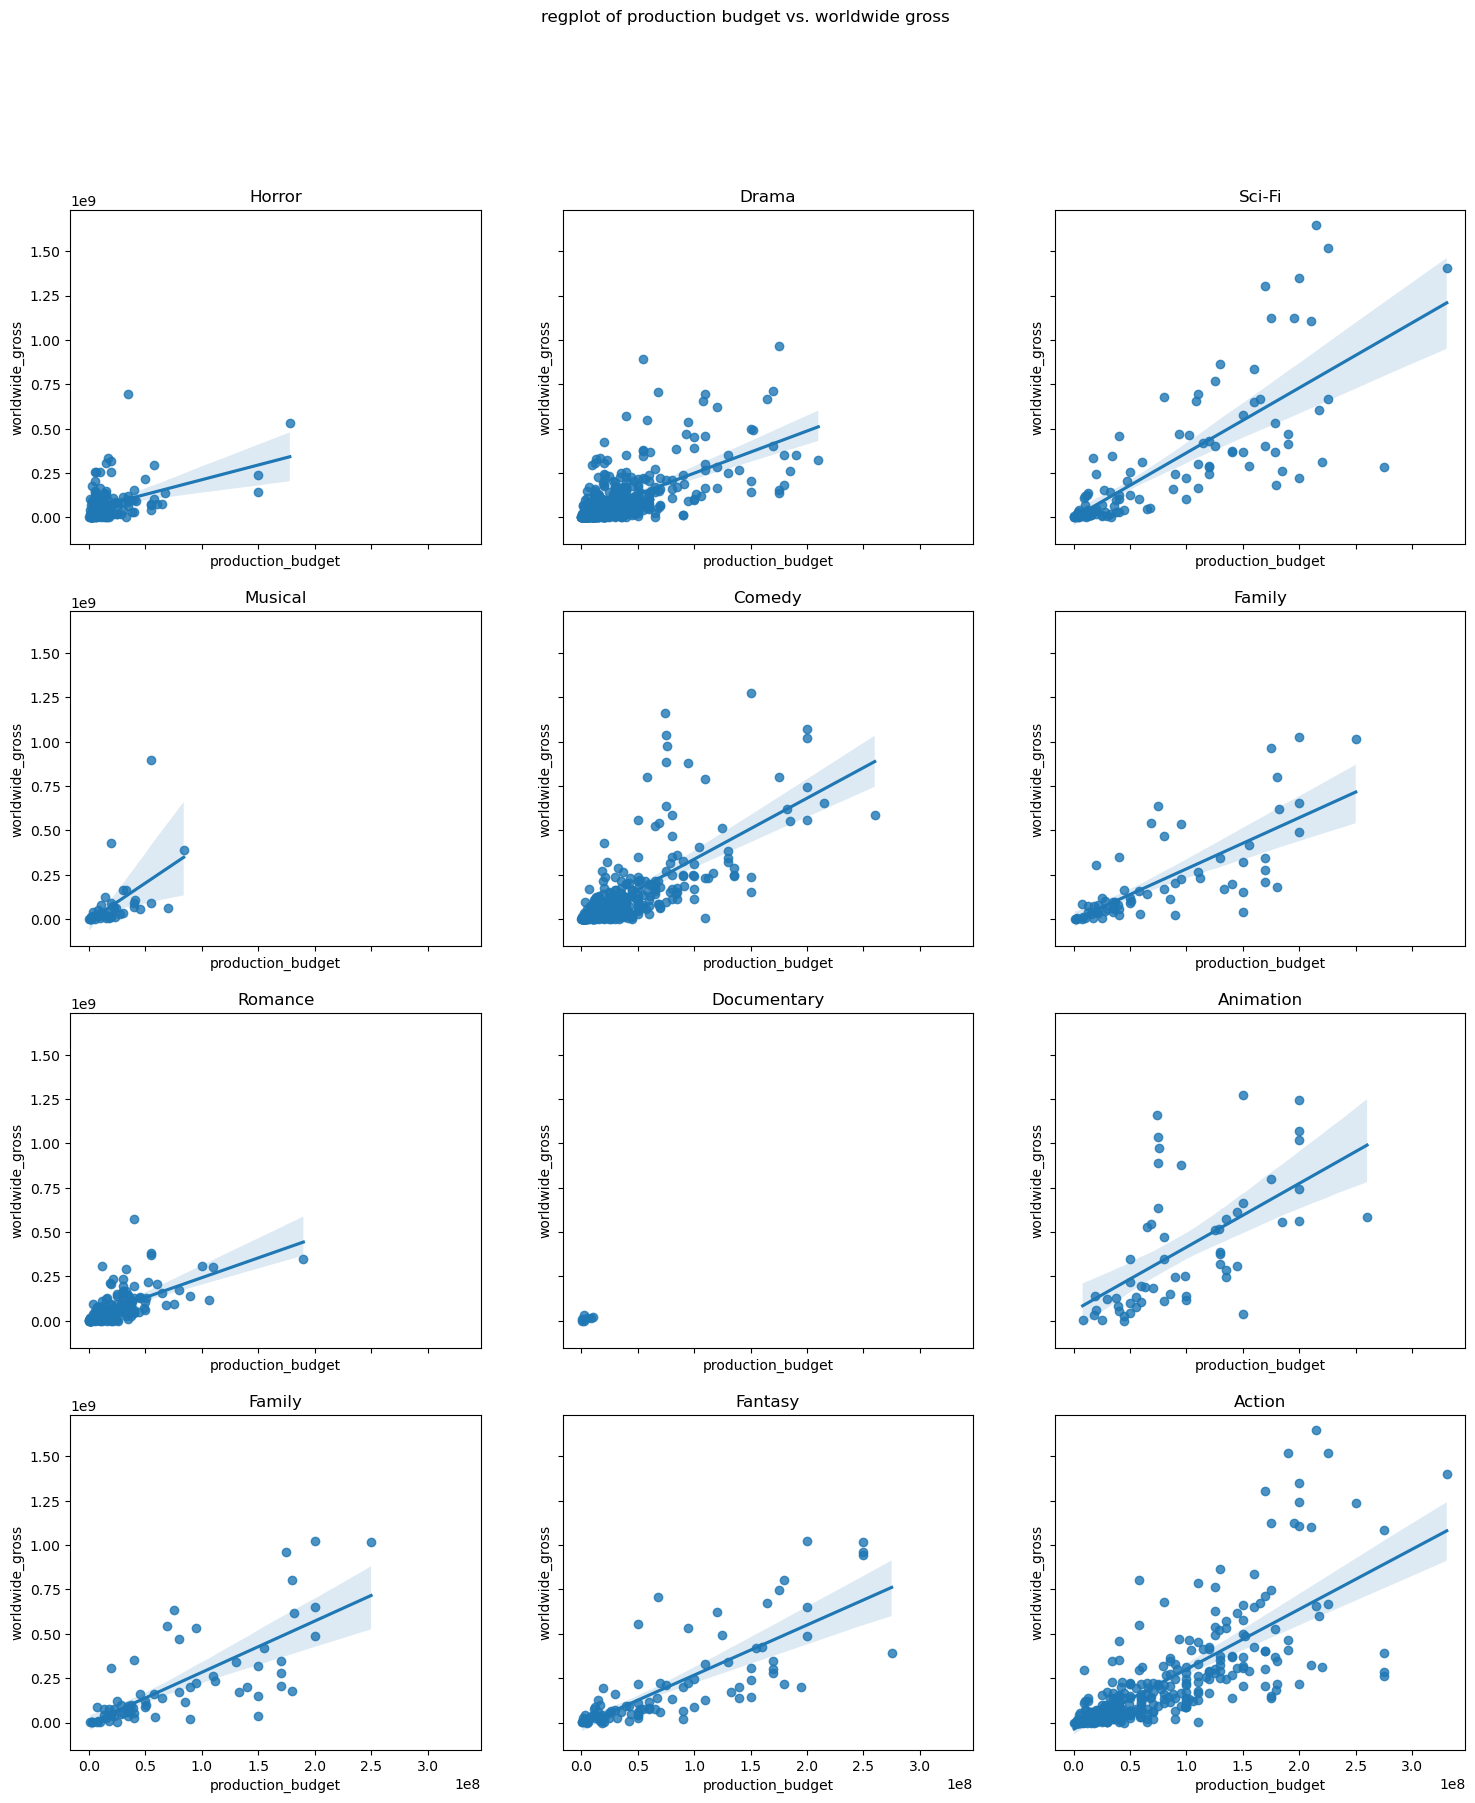

In [15]:
df=returnGenreFrames(woMDdf250count,'Horror')
fig, axes = plt.subplots(4,3, figsize=(18, 20), sharey=True,sharex=True)
fig.suptitle('regplot of production budget vs. worldwide gross') 
sns.regplot(ax=axes[0, 0], data=returnGenreFrames(woMDdf250count,'Horror'), x='production_budget', y='worldwide_gross').set(title='Horror')
sns.regplot(ax=axes[0, 1], data=returnGenreFrames(woMDdf250count,'Drama'), x='production_budget', y='worldwide_gross').set(title='Drama')
sns.regplot(ax=axes[0, 2], data=returnGenreFrames(woMDdf250count,'Sci-Fi'), x='production_budget', y='worldwide_gross').set(title='Sci-Fi')
sns.regplot(ax=axes[1, 0], data=returnGenreFrames(woMDdf250count,'Musical'), x='production_budget', y='worldwide_gross').set(title='Musical')
sns.regplot(ax=axes[1, 1], data=returnGenreFrames(woMDdf250count,'Comedy'), x='production_budget', y='worldwide_gross').set(title='Comedy')
sns.regplot(ax=axes[1, 2], data=returnGenreFrames(woMDdf250count,'Family'), x='production_budget', y='worldwide_gross').set(title='Family')
sns.regplot(ax=axes[2, 0], data=returnGenreFrames(woMDdf250count,'Romance'), x='production_budget', y='worldwide_gross').set(title='Romance')
sns.regplot(ax=axes[2, 1], data=returnGenreFrames(woMDdf250count,'Documentary'), x='production_budget', y='worldwide_gross').set(title='Documentary')
sns.regplot(ax=axes[2, 2], data=returnGenreFrames(woMDdf250count,'Animation'), x='production_budget', y='worldwide_gross').set(title='Animation')
sns.regplot(ax=axes[3, 0], data=returnGenreFrames(woMDdf250count,'Family'), x='production_budget', y='worldwide_gross').set(title='Family')
sns.regplot(ax=axes[3, 1], data=returnGenreFrames(woMDdf250count,'Fantasy'), x='production_budget', y='worldwide_gross').set(title='Fantasy')
sns.regplot(ax=axes[3, 2], data=returnGenreFrames(woMDdf250count,'Action'), x='production_budget', y='worldwide_gross').set(title='Action')

From the above graphs, I've decided that Microsoft should focus on animated films.  Animated films are most likely, along with Comedy, to perform disproportionately well in the moderate budget range.  Unlike Comedy, the starting y-value of the linear regression line is high, which means that they are less likely to flop.  Below, I examine Horror and Documentary in greater detail to explore producing these films as a secondary focus.

[Text(0.5, 1.0, 'Documentary')]

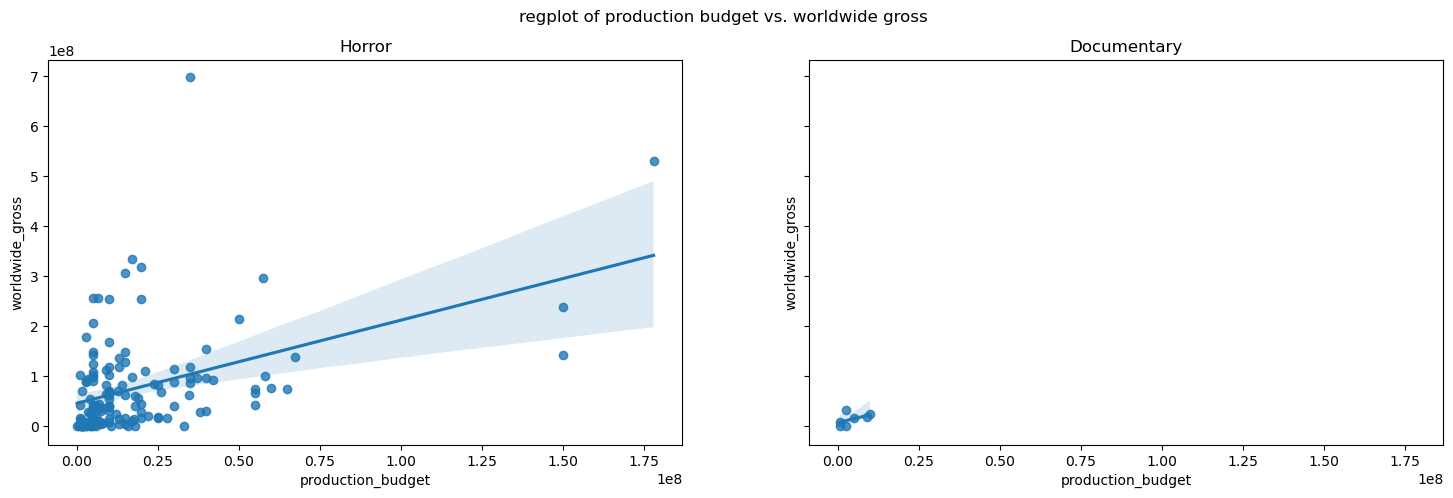

In [16]:
fig, axes = plt.subplots(1,2, figsize=(18, 5), sharey=True,sharex=True)
fig.suptitle('regplot of production budget vs. worldwide gross') 
sns.regplot(ax=axes[0], data=returnGenreFrames(woMDdf250count,'Horror'), x='production_budget', y='worldwide_gross').set(title='Horror')
sns.regplot(ax=axes[1], data=returnGenreFrames(woMDdf250count,'Documentary'), x='production_budget', y='worldwide_gross').set(title='Documentary')

Horror has many heavy outliers.  What happens if we remove the top ten highest grossing horror films from the dataset? Mean ROI decreases from 8.16 dollars earned / dollars spent to 5.24 dollars earned / dollars spent, which is much closer to Documentary with its ROI of 4.41.  Documentary has few data points, but this could be advantageous as it represents an undersaturated market.

In [17]:
df=returnGenreFrames(woMDdf250count,'Horror')
df=df.sort_values(by='gross_per_$', ascending=False)
dfminus3=df.tail(131)
dfminus3['gross_per_$'].mean()

5.240383165397653

# Microsoft should produce animation films and spent a small amount of money producing low budget documentaries, to try to capture the undersaturated market.  Who should they hire to make these films?
First, I examine Animation.  Hiring successful writers and actors does not have much impact on ROI.  
There is a large correlation between ROI and hiring successful producers and directors.  Microsoft should hire established producers and directors to create their animation films.

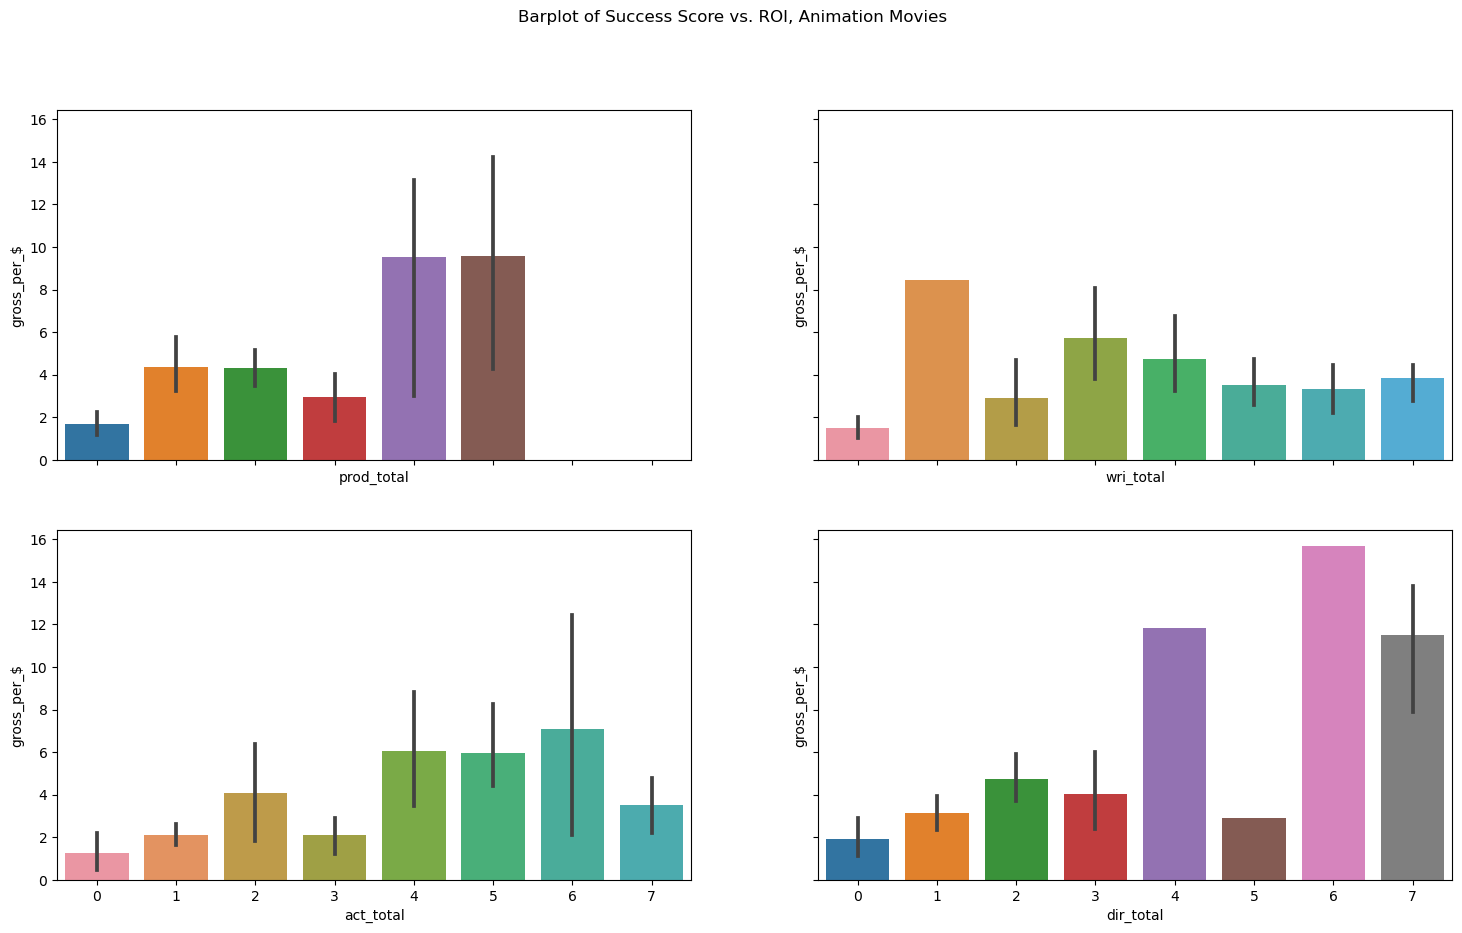

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True, sharex=True)
tempDF=returnGenreFrames(woMDdf250count,'Animation') 
fig.suptitle('Barplot of Success Score vs. ROI, Animation Movies')
tempDF=returnGenreFrames(woMDdf250count,'Animation') 
sns.barplot(ax=axes[0, 0], data=tempDF, x='prod_total', y='gross_per_$')
sns.barplot(ax=axes[0, 1], data=tempDF, x='wri_total', y='gross_per_$')
sns.barplot(ax=axes[1, 0], data=tempDF, x='act_total', y='gross_per_$')
sns.barplot(ax=axes[1, 1], data=tempDF, x='dir_total', y='gross_per_$')
plt.show()

Next, I examine Documentary films.  This gives inconclusive results - since there are few datapoints, there appears to be no advantage from hiring within any specific category. From the above statistics chart, however, we can see that the correlation betwen success score and worldwide gross is fairly low.  

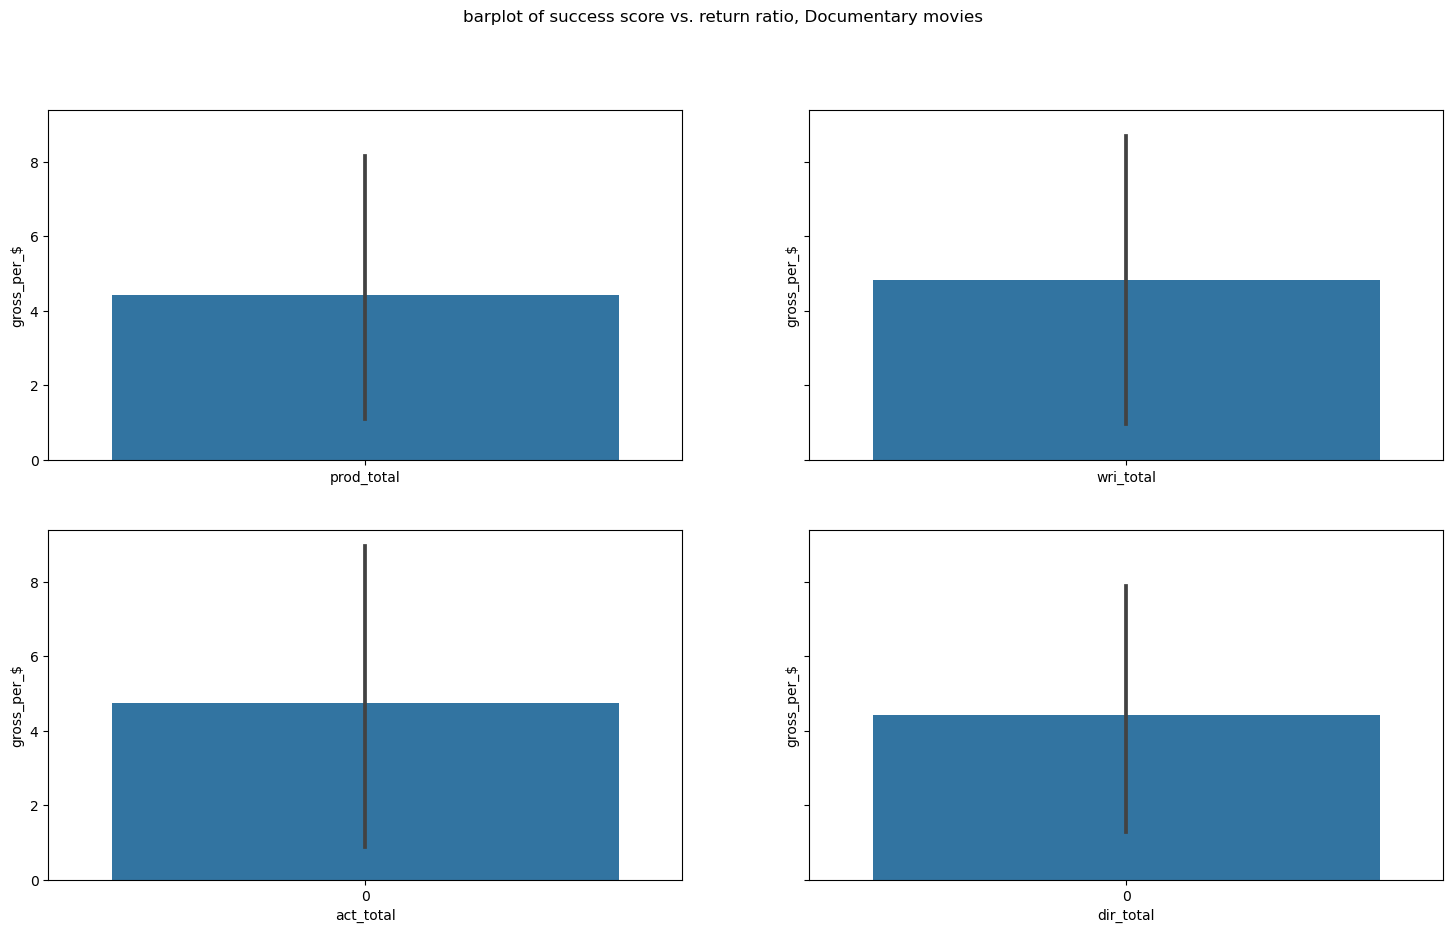

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True, sharex=True)
fig.suptitle('barplot of success score vs. return ratio, Documentary movies')
tempDF=returnGenreFrames(woMDdf250count,'Documentary') 
sns.barplot(ax=axes[0, 0], data=tempDF, x='prod_total', y='gross_per_$')
sns.barplot(ax=axes[0, 1], data=tempDF, x='wri_total', y='gross_per_$')
sns.barplot(ax=axes[1, 0], data=tempDF, x='act_total', y='gross_per_$')
sns.barplot(ax=axes[1, 1], data=tempDF, x='dir_total', y='gross_per_$')
plt.show()

# Final Recommendation
Microsoft should focus primarily on making low to moderate budget animation films, since these are less likely to flop and are capable of performing much better in relation to their cost than most other genres.  For these low to moderate budget animation films, they should hire very successful producers and directors, and can hire any actors or writers they want.  They should also devote a small amount of resources to creating low budget documentaries, since this is a underexploited market that frequently yields a high return on investment.  For these documentaries, they do not need to hire established people.  